In [225]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import nibabel as nib
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow_addons as tfa
import glob
import scipy

In [226]:
def window_image(img, minn,maxx, intercept, slope, rescale=True):
    img = (img*slope +intercept) 
    
    img[img<minn] = minn 
    img[img>maxx] = maxx 
    if rescale: 
        img = (img - minn) / (maxx - minn)
    return img
    
def get_first_of_dicom_field_as_int(x):
    if type(x) == dcm.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value,
                    data[('0028','1051')].value,
                    data[('0028','1052')].value,
                    data[('0028','1053')].value]
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
def channeling(img1, img2, img3):
    return np.stack([img1, img2, img3], axis=-1)
def load_data(UID):
    data_path = '../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_images/'
    data = dcm.dcmread(data_path+UID+'/'+os.listdir(data_path+UID)[0])
    _, _, intercept, slope = get_windowing(data)
    return intercept, slope

In [227]:
df = pd.read_csv('../../Downloads/rsna-2022-cervical-spine-fracture-detection/train.csv')

In [240]:
IMAGE_SIZE = 128
BATCH_SIZE = 4
NUM_CLASSES = 9
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

In [241]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)


In [242]:
path_seg = '../../Downloads/rsna-2022-cervical-spine-fracture-detection/segmentations/'

In [243]:
patients = os.listdir(path_seg)
patients[0]

'1.2.826.0.1.3680043.10633.nii'

In [244]:
def seg_extractor(UID):
    seg = nib.load(path_seg+UID+'.nii')
    seg = seg.get_fdata()
    seg = np.transpose(seg, axes=[2,1,0])
    seg = scipy.ndimage.zoom(seg, (128/seg.shape[0],128/seg.shape[1],128/seg.shape[2]), order=1)
    return seg[::-1,::-1,:]
def ct_extractor(UID):
    img = nib.load(path_img+UID+'.nii.gz')
    img = img.get_fdata()
    img = scipy.ndimage.zoom(img, (128/img.shape[0],1,1), order=1)
    return img


In [245]:
def data_gen():
    for patient in patients[:75]:
        patient = patient[:-4]
        intercept, slope = load_data(patient)
        ct = ct_extractor(patient)
        ct1 = window_image(ct,150,300,intercept,slope)
        ct2 = window_image(ct,300,450,intercept,slope)
        ct3 = window_image(ct,450,600,intercept,slope)
        ct = channeling(ct1,ct2,ct3)
        seg = seg_extractor(patient)
        seg[np.where(seg>8)] = 8
        for image in range(28,100):
            yield ct[:,:,image], seg[:,:,image]

In [246]:
def test_gen():
    for patient in patients[75:]:
        patient = patient[:-4]
        intercept, slope = load_data(patient)
        ct = ct_extractor(patient)
        ct1 = window_image(ct,150,300,intercept,slope)
        ct2 = window_image(ct,300,450,intercept,slope)
        ct3 = window_image(ct,450,600,intercept,slope)
        ct = channeling(ct1,ct2,ct3)
        seg = seg_extractor(patient)
        seg[np.where(seg>8)] = 8
        for image in range(28,100):
            yield ct[:,:,image], seg[:,:,image]

In [247]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     (tf.float32, tf.int8),
    (tf.TensorShape([128,128,3]), tf.TensorShape([128,128]))
)

testset = tf.data.Dataset.from_generator(
     test_gen,
     (tf.float32, tf.int8),
    (tf.TensorShape([128,128,3]), tf.TensorShape([128,128]))
)

In [248]:
dataset = dataset.batch(36)
dataset = dataset.prefetch(2)


testset = testset.batch(72)
testset = testset.prefetch(2)

In [249]:
!mkdir seg_best_weights

A subdirectory or file seg_best_weights already exists.


In [250]:
def lr_schedule(epoch, lr):
    if epoch%4==0 and epoch!=0:
        return lr/2
    else:
        return lr
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = './seg_best_weights/model',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

In [252]:
history = model.fit(dataset, validation_data=testset, epochs=40, callbacks=[model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/40
150/150 [==============================] - 76s 502ms/step - loss: 0.1372 - accuracy: 0.9593 - val_loss: 0.2596 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 2/40
150/150 [==============================] - 76s 500ms/step - loss: 0.1052 - accuracy: 0.9667 - val_loss: 0.4103 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 3/40
150/150 [==============================] - 78s 514ms/step - loss: 0.0914 - accuracy: 0.9703 - val_loss: 0.3392 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 4/40
150/150 [==============================] - 80s 528ms/step - loss: 0.0874 - accuracy: 0.9717 - val_loss: 0.2638 - val_accuracy: 0.9496 - lr: 0.0010
Epoch 5/40
150/150 [==============================] - 81s 538ms/step - loss: 0.0799 - accuracy: 0.9740 - val_loss: 0.2127 - val_accuracy: 0.9521 - lr: 5.0000e-04
Epoch 6/40
150/150 [==============================] - 83s 549ms/step - loss: 0.0757 - accuracy: 0.9753 - val_loss: 0.1239 - val_accuracy: 0.9614 - lr: 5.0000e-04
Epoch 7/40
150/150 [========================

In [253]:
model.load_weights('./seg_best_weights/model')

In [254]:
a = model.predict(testset.take(1))

1/1 [==============================] - 3s 3s/step


In [255]:
df

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


In [256]:
'1.2.826.0.1.3680043.12351' in patients

False

In [257]:
sample_ct = ct_extractor('1.2.826.0.1.3680043.12351')

In [258]:
sample_ct.shape

(128, 128, 128)

In [259]:
def sample_creator(patient):
    intercept, slope = load_data(patient)
    ct = ct_extractor(patient)
    ct = np.transpose(ct, axes = [2,0,1])
    ct1 = window_image(ct,150,300,intercept,slope)
    ct2 = window_image(ct,300,450,intercept,slope)
    ct3 = window_image(ct,450,600,intercept,slope)
    ct = channeling(ct1,ct2,ct3)
    return ct

In [285]:
a = sample_creator('1.2.826.0.1.3680043.18786')

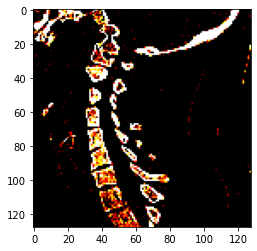

In [286]:
plt.imshow(a[64])

In [287]:
pred = model.predict(a)

4/4 [==============================] - 1s 190ms/step


In [288]:
pred = np.argmax(pred, axis=-1)

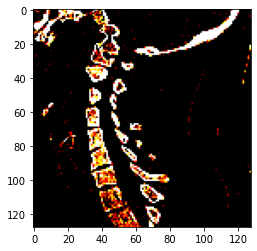

In [289]:
plt.imshow(a[64])

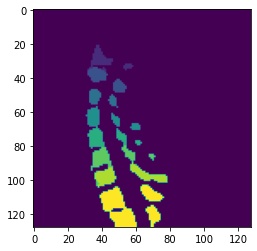

In [290]:
#pred[64][np.where(pred[64]!=6)]=0
plt.imshow(pred[64])

In [266]:
np.where(pred[64] == 0)[0]

array([  0,   0,   0, ..., 127, 127, 127], dtype=int64)